# ***Imports***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# ***Preprocessing and Data Exploration***

***Device***

In [ ]:
if torch.cuda.is_available():     
  device = torch.device('cuda')    
else:
  device = torch.device('cpu')

***Data Merging, Shuffling and Splitting***

In [ ]:
s1 = pd.read_csv("Batch1.tsv", delimiter='\t', encoding='utf-8')
s2 = pd.read_csv("Batch2.tsv", delimiter='\t', encoding='utf-8')
s3 = pd.read_csv("Test.csv", delimiter=',', encoding='utf-8')
data_p_false=s2[s2['our rating']=='partially false']
data_true=s2[s2['our rating']=='true']
data_other=s2[s2['our rating']=='other']
s2=(data_p_false.append(data_true)).append(data_other)
s2 = s2.sample(frac=1, random_state = 24).reset_index(drop=True)
sample = pd.concat([s1,s2])
sample = sample.sample(frac = 1)
print(Counter(sample['our rating'].values))
train = sample
test = s3

test_ids = test['public_id']

print(f'Number of inputs in test: {test.shape[0]}\n')
print(f'Number of inputs in train: {train.shape[0]}\n')

Counter({'false': 315, 'partially false': 217, 'true': 142, 'other': 76})
Number of inputs in test: 364

Number of inputs in train: 750



***Turning column 'our rating' into encoded column 'labels' with numbers instead of text***

In [ ]:
print(test.sample(5))
test.drop(['our rating'], axis = 1, inplace = True)

target_var2 = train['our rating'].values
encoder = LabelEncoder()
labels = encoder.fit_transform(target_var2)
train['label'] = labels
train.drop(['our rating'], axis = 1, inplace = True)

idx = len(labels)

    public_id                                               text  \
157  87a297a2  The NHS Long Term Plan, published today, will ...   
123  96b47cba  White House press secretary Sarah Huckabee San...   
289  caa34051  A domino-like cascade of melting ice, warming ...   
143  cef0a3d1  Occupation: President and CEO, Bettencourt Tax...   
332  1393bc27  I’m not sure the whole thing isn’t crazy, this...   

                                                 title  our rating  
157  NHS Long Term Plan to tackle major killer cond...         NaN  
123  Affordable Housing Impact Statements could gui...         NaN  
289  Domino-effect of climate events could move Ear...         NaN  
143  The CDC has admitted face masks do little to p...         NaN  
332  James Lovelock: ‘Before the end of this centur...         NaN  


***Data exploration in order to see the layout of our labels*** <br>
***0 - False*** <br>
***1 - Other*** <br>
***2 - Partially False*** <br>
***3 - True***

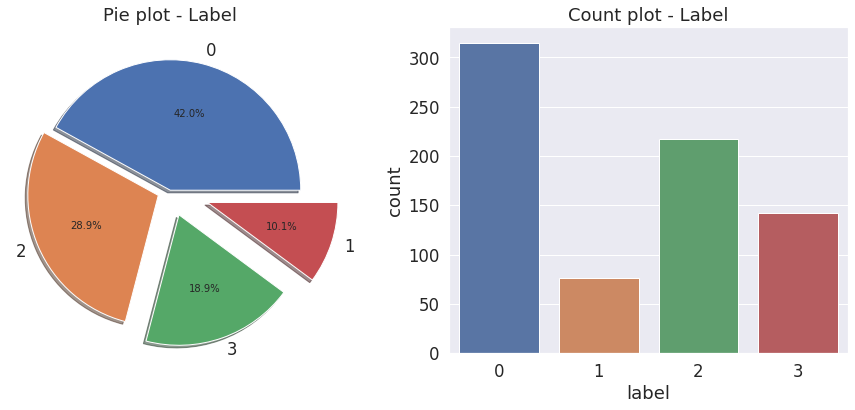

In [ ]:
f,ax = plt.subplots(1,2,figsize=(14,6))
train['label'].value_counts().plot.pie(explode=[0, 0.1, 0.2, 0.3],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Label')
ax[0].set_ylabel('')
sns.countplot('label', data = train, ax=ax[1])
ax[1].set_title('Count plot - Label')
plt.show()

***Some WordClouds to bettere see the data distribution***

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train[train.label == 0].text))
plt.axis('off')
plt.title('False News')
plt.imshow(wc,interpolation = 'bilinear')

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train[train.label == 1].text))
plt.axis('off')
plt.title('True News')
plt.imshow(wc,interpolation = 'bilinear')

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train[train.label == 2].text))
plt.axis('off')
plt.title('Other News')
plt.imshow(wc,interpolation = 'bilinear')

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train[train.label == 3].text))
plt.axis('off')
plt.title('Partially False News')
plt.imshow(wc,interpolation = 'bilinear')

***Concatenating the title with the text and dropping unnecessary columns***

In [ ]:
train['text'].fillna("", inplace=True)
test['text'].fillna("", inplace=True)

train['text'] = train['title'] + " " + train['text']
test['text'] = test['title'] + " " + test['text']

train.drop(['public_id','title'], axis=1, inplace=True)
test.drop(['public_id','title'], axis=1, inplace=True)

***Defining some adjuvant functions for preprocessing the text***

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def floatToString(text):
    try:
      float(text)
      return str(text)
    except ValueError:
      return text

def line_removal(text):
    all_list = [char for char in text if char not in "…-–—_©“”‘’•⋆»"]
    clean_str = ''.join(all_list)
    return clean_str

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

def preprocess(text,stem=False):
    text = floatToString(text)
    text = text.lower()
    text = line_removal(text)
    text = punctuation_removal(text)
    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()
    text = re.sub(r'&amp;?', r'and', text)
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
                               u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                               u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

# ***Modelling***

***Combining the 'text' columns from test and train, tokenizing it and mapping the tokens to their word IDs.***

In [ ]:
train['text'] = train['text'].apply(lambda x: preprocess(x))
test['text'] = test['text'].apply(lambda x: preprocess(x))

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

combined = pd.concat([test,train])
combined = combined['text'].values

print('Texts: ', combined[0])
print('Tokenized texts: ', tokenizer.tokenize(combined[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

***Formatting the train and test DataFrames in order to avoid getting a size mismatch when creating the TensorDataset***

In [ ]:
train = combined[:idx]
test = combined[idx:]
train.shape

(750,)

***Further formatting the text, tokenizing the sentences, prepending and appending with the [CLS] and [SEP] tokens, mapping the tokens, truncating each sentence in order to fit our constraints and finally creating attention masks***

In [ ]:
def tokenize_map(sentence,labs='None'):
    global labels
    input_ids = []
    attention_masks = []
    
    for text in sentence:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        
        encoded_dict = tokenizer.encode_plus(
                            text,                      
                            add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                            truncation='longest_first',   # Activate and control truncation
                            max_length = 72,              # Max length according to our current RAM constraints.
                            pad_to_max_length = True,     # Pad & truncate all sentences.
                            return_attention_mask = True, # Construct attn. masks.
                            return_tensors = 'pt',        # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list.         
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (differentiates padding from non-padding).        
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [ ]:
input_ids, attention_masks, labels = tokenize_map(train, labels)
test_input_ids, test_attention_masks= tokenize_map(test)

In [ ]:
decode = tokenizer.decode(input_ids[0])
decode

***Create the TensorDataset and splitting the train data (from the TensorDataset data) in order to create a 80-20 split for training-validation***

In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate the number of samples to include in each set.

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  675 training samples
   75 validation samples


# ***Fine-Tuning***

***Creating the DataLoaders for the Training and Validation sets***

In [ ]:
batch_size = 12

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # Training samples.
            sampler = RandomSampler(train_dataset), # Random Batches.
            batch_size = batch_size # Batch Size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # Validation Samples.
            sampler = SequentialSampler(val_dataset), # Sequencial Batch Selection.
            batch_size = batch_size # Batch Size.
)

prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

***Loading the pretrained BERT model (single linear classification)***

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', # 124-layers, 1024-hidden, 16-heads, 340M parameters BERT model, Uncased Vocab.
    num_labels = 4, # We have 4 output labels -- False, Possibly False, Other and True   
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device)

***Optimizer SetUp***

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # Learning Rate
                  eps = 1e-8 # Adam Epsilon
                )

***Setting up Epochs, Training Steps and Learning Rate Scheduler***

In [ ]:
epochs = 3

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

***Function to help keep track of Elapsed Time, Accuracy and F1***

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat,average='micro')

def format_time(elapsed):    
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# ***Training and Validation Phase***

In [ ]:
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ----- TRAINING -----

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    t0 = time.time()
    total_train_loss = 0
    
    model.train()   
    for step, batch in enumerate(train_dataloader):

        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)
        
        model.zero_grad()        
        loss = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[0]
        logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[1]
        
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()    
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)               
    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epoch took: {:}'.format(training_time))
        
    # ----- VALIDATION -----

    print('')
    print('Running Validation...')

    t0 = time.time()
    model.eval()
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0
    
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            loss = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[0]

            logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[1]
        
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)
    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    10  of     57.    Elapsed: 0:00:08.
  Batch    20  of     57.    Elapsed: 0:00:16.
  Batch    30  of     57.    Elapsed: 0:00:23.
  Batch    40  of     57.    Elapsed: 0:00:31.
  Batch    50  of     57.    Elapsed: 0:00:39.

  Average training loss: 1.31
  Training epoch took: 0:00:44

Running Validation...
  Accuracy: 0.50
  F1: 0.50
  Validation Loss: 1.26
  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...
  Batch    10  of     57.    Elapsed: 0:00:08.
  Batch    20  of     57.    Elapsed: 0:00:16.
  Batch    30  of     57.    Elapsed: 0:00:24.
  Batch    40  of     57.    Elapsed: 0:00:33.
  Batch    50  of     57.    Elapsed: 0:00:41.

  Average training loss: 1.30
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.49
  F1: 0.49
  Validation Loss: 1.25
  Validation took: 0:00:03

======== Epoch 3 / 3 ========
Training...
  Batch    10  of     57.    Elapsed: 0:00:09.
  Batch    20  of     57. 

***Displaying Training Stats Table***

In [ ]:
pd.set_option('precision', 3)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
display(df_stats)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,1.311,1.260,0.500,0.500,0:00:44,0:00:02
2,1.295,1.253,0.488,0.488,0:00:47,0:00:03
3,1.256,1.244,0.500,0.500,0:00:50,0:00:03


***Generating Training and Validation Loss Graph***

([<matplotlib.axis.XTick at 0x7fd302eba590>,
 <a list of 2 Text major ticklabel objects>)

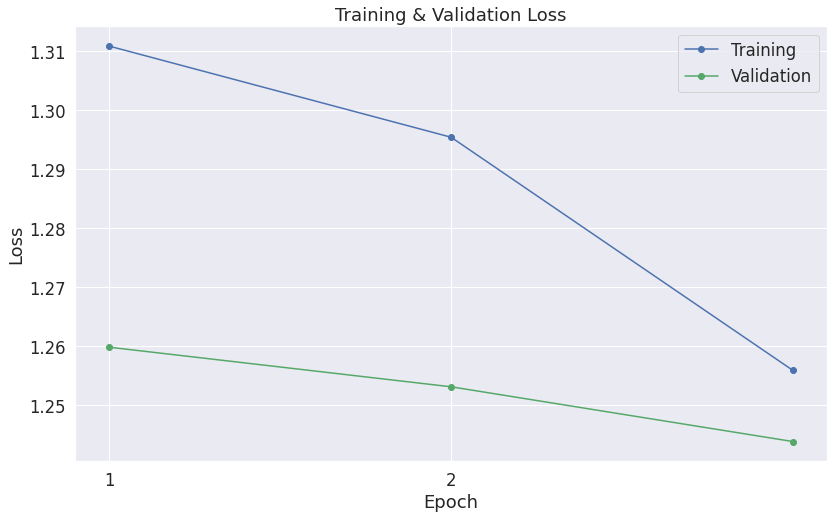

In [ ]:
fig, axes = plt.subplots(figsize=(12,8))

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2])

#plt.show()

# ***Predictions***

In [ ]:
import re
import nltk
import argparse
import tensorflow as tf


class Model:
    def __init__(self, text):
        self.text = text

    def download_dependencies(self):
        pass

    def process_text(self):
        pass

    def predict(self):
        pass

    def load_model():
        pass

class BertModel(Model):
    def __init__(self, text):
        super().__init__(text)

    def process_text(self):
        preprocess(self.text) 
    
    def load_model():
      filename = 'finalized_model.sav'
      pickle.dump(model, open(filename, 'wb'))
      self=pickle.load(open(filename, 'rb'))

if __name__ == '__main__':
    BertModel(test[0])
    print(test[0])

rep david mckinley call increase border patrol agent rank wheeling least 53 million week illegal drug cross mexican border u week border agent needed usmexican border stop according u rep david b mckinley mckinley rwva recently traveled usmexican border learn issue first hand visited mcallen texas region rio grande district u border patrol commended work border agent put danger try keep border clean secure theyve done decade mckinley said compounded humanitarian crisis didnt always many people trying cross illegally agent attempt still security job put many pulled line take care humanitarian crisis border mckinley learned mexican drug cartel control happening border spoke immigrant detained border told paid cartel anywhere 3000 9000 get across border often part deal immigrant carry illegal drug journey immigrant captured sent back village must start seek help cartel mckinley said one border officer said cartel might making much money drug said border guard lot tool help track immigrant

***Serializing and saving the model and generating predictions on the test set***

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))
import pickle 
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
model=pickle.load(open(filename, 'rb'))
model.eval()
predictions = []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch) 
  b_input_ids, b_input_mask, = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]    
  logits = logits.detach().cpu().numpy()
  predictions.append(logits)

print('    DONE.')

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

preds = pd.DataFrame()
preds["public_id"] = test_ids
preds["our rating"] = flat_predictions

pred1=[]
for i in range(len(preds)):
    if preds['our rating'][i]==0:
         preds['our rating'][i]='false'
    if preds['our rating'][i]==3:
        preds['our rating'][i]='true'
    if preds['our rating'][i]==1:
        preds['our rating'][i]='other'
    if preds['our rating'][i]==2:
        preds['our rating'][i]='partially false'
preds.to_csv("results.csv")
s4 = pd.read_csv("results.csv", delimiter=',', encoding='utf-8')
s4

